 # DPO Model Evaluation with RewardBench



 This notebook evaluates a DPO (Direct Preference Optimization) fine-tuned model using RewardBench.

 DPO models are evaluated by comparing their log probabilities on chosen vs rejected responses.

 ## 1. Install Dependencies

In [100]:
!pip install -q transformers torch pandas accelerate matplotlib seaborn tqdm
!pip install -q rewardbench


 ## 2. Import Libraries

In [101]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


 ## 3. Configuration

In [ ]:
# Model checkpoint path: model fine-tuned using DPO
CHECKPOINT_PATH = ""

# Reference model (optional - for computing implicit reward)
REFERENCE_MODEL_PATH = "gpt2"  # Base model before DPO training

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Evaluation settings
BATCH_SIZE = 1
MAX_LENGTH = 512
SUBSET = "chat"  # Options: 'chat', 'chat_hard', 'safety', 'reasoning'
BETA = 0.1  # DPO temperature parameter (typically 0.1)

# Use reference model for implicit reward calculation?
# USE_REFERENCE_MODEL = False
USE_REFERENCE_MODEL = True

print(f"Checkpoint: {CHECKPOINT_PATH}")
print(f"RewardBench subset: {SUBSET}")
print(f"Beta (DPO temperature): {BETA}")


Using device: cuda
Checkpoint: /content/drive/Othercomputers/My Mac/Google Drive/Colab Notebooks/Reinforcement-learning/outputs/gpt2/checkpoint-3000
RewardBench subset: chat
Beta (DPO temperature): 0.1


 ## 4. Load DPO Model and Tokenizer

In [103]:
print(f"Loading DPO model from: {CHECKPOINT_PATH}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_PATH)

# Ensure pad token is set (required for GPT-2 based models)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Set pad_token to eos_token")

# Load DPO model
model = AutoModelForCausalLM.from_pretrained(
    CHECKPOINT_PATH,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
)
if REFERENCE_MODEL_PATH == 'gpt2':
  gpt2_chat_template = r"""\
  {%- set sep = '\n\n' -%}
  {%- for m in messages -%}
  {%- if m['role'] == 'human' -%}
  Human: {{ m['content'] | trim }}{{ sep }}
  {%- elif m['role'] == 'assistant' -%}
  Assistant: {{ m['content'] | trim }}{{ sep }}
  {%- endif -%}
  {%- endfor -%}
  """
  # Attach at runtime:
  tokenizer.chat_template = gpt2_chat_template
model.to(DEVICE)
model.eval()

# Set pad token id in model config
if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.pad_token_id

print(f"✓ DPO model loaded successfully on {DEVICE}")
print(f"Model type: {model.config.model_type}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Loading DPO model from: /content/drive/Othercomputers/My Mac/Google Drive/Colab Notebooks/Reinforcement-learning/outputs/gpt2/checkpoint-3000
✓ DPO model loaded successfully on cuda
Model type: gpt2
Total parameters: 124,439,808


 ## 5. Load Reference Model (Optional)

In [104]:
reference_model = None

if USE_REFERENCE_MODEL:
    print(f"\nLoading reference model from: {REFERENCE_MODEL_PATH}")

    reference_model = AutoModelForCausalLM.from_pretrained(
        REFERENCE_MODEL_PATH,
        torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
    )

    reference_model.to(DEVICE)
    reference_model.eval()

    print(f"✓ Reference model loaded successfully")
else:
    print("\nSkipping reference model (USE_REFERENCE_MODEL=False)")



Loading reference model from: gpt2
✓ Reference model loaded successfully


 ## 6. Define DPO Reward Functions

In [105]:
def get_log_prob(model, prompt, response):
    """
    Calculate the log probability of a response given a prompt.
    This is the key metric for evaluating DPO models.
    """
    # Combine prompt and response
    full_text = prompt + response

    # Tokenize
    inputs = tokenizer(
        full_text,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LENGTH
    ).to(DEVICE)

    # Also tokenize just the prompt to know where response starts
    prompt_inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LENGTH
    ).to(DEVICE)

    prompt_length = prompt_inputs["input_ids"].shape[1]

    # Get logits
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get log probabilities for the response tokens only
    # Shift logits and labels for next-token prediction
    shift_logits = logits[:, prompt_length-1:-1, :]
    shift_labels = inputs["input_ids"][:, prompt_length:]

    # Calculate log probabilities
    log_probs = torch.nn.functional.log_softmax(shift_logits, dim=-1)

    # Gather log probs for actual tokens
    token_log_probs = torch.gather(
        log_probs,
        2,
        shift_labels.unsqueeze(-1)
    ).squeeze(-1)

    # Sum log probs (or mean for normalized score)
    total_log_prob = token_log_probs.sum().item()
    mean_log_prob = token_log_probs.mean().item()

    return {
        "total_log_prob": total_log_prob,
        "mean_log_prob": mean_log_prob,
        "num_tokens": shift_labels.shape[1]
    }

def get_dpo_implicit_reward(prompt, response):
    """
    Calculate DPO implicit reward: beta * log(pi_theta(y|x) / pi_ref(y|x))
    where pi_theta is the DPO model and pi_ref is the reference model.
    """
    if reference_model is None:
        # Without reference model, just use the DPO model's log prob
        result = get_log_prob(model, prompt, response)
        return result["mean_log_prob"]

    # Get log probs from both models
    dpo_result = get_log_prob(model, prompt, response)
    ref_result = get_log_prob(reference_model, prompt, response)

    # Calculate implicit reward
    log_ratio = dpo_result["total_log_prob"] - ref_result["total_log_prob"]
    implicit_reward = BETA * log_ratio

    return implicit_reward

def get_dpo_preference_score(prompt, chosen, rejected):
    """
    Calculate DPO preference score between chosen and rejected responses.
    Returns the difference in rewards (should be positive if model prefers chosen).
    """
    reward_chosen = get_dpo_implicit_reward(prompt, chosen)
    reward_rejected = get_dpo_implicit_reward(prompt, rejected)

    return {
        "reward_chosen": reward_chosen,
        "reward_rejected": reward_rejected,
        "margin": reward_chosen - reward_rejected,
        "correct": reward_chosen > reward_rejected
    }

# Test the functions
print("\nTesting DPO scoring functions...")
test_prompt = "What is the capital of France?"
test_response = "The capital of France is Paris."
test_result = get_log_prob(model, test_prompt, test_response)
print(f"Test log prob (mean): {test_result['mean_log_prob']:.4f}")
print(f"Test num tokens: {test_result['num_tokens']}")



Testing DPO scoring functions...
Test log prob (mean): -3.3398
Test num tokens: 7


 ## 7. Simple Evaluation (Quick Test)

In [106]:
print("Running simple evaluation with test cases...\n")

test_cases = [
    {
        "prompt": "What is the capital of France?",
        "chosen": "The capital of France is Paris.",
        "rejected": "I don't know."
    },
    {
        "prompt": "Explain quantum computing simply.",
        "chosen": "Quantum computing uses quantum mechanics principles like superposition and entanglement to process information in ways classical computers cannot, potentially solving certain problems exponentially faster.",
        "rejected": "It's just computers but quantum."
    },
    {
        "prompt": "How do I make pasta?",
        "chosen": "To make pasta: 1) Boil water with salt, 2) Add pasta and stir, 3) Cook for 8-10 minutes until al dente, 4) Drain and serve with your favorite sauce.",
        "rejected": "Just put it in water."
    },
    {
        "prompt": "Tell me about machine learning.",
        "chosen": "Machine learning is a branch of artificial intelligence that enables computers to learn from data and improve their performance without being explicitly programmed. It uses algorithms to identify patterns and make predictions.",
        "rejected": "ML is just algorithms and stuff."
    },
    {
        "prompt": "What causes seasons on Earth?",
        "chosen": "Seasons are caused by Earth's axial tilt of 23.5 degrees. As Earth orbits the Sun, different hemispheres receive varying amounts of direct sunlight throughout the year.",
        "rejected": "The Earth moves around and it gets cold sometimes."
    }
]

simple_results = []

for idx, case in enumerate(test_cases):
    result = get_dpo_preference_score(case["prompt"], case["chosen"], case["rejected"])

    simple_results.append({
        "ID": idx + 1,
        "Prompt": case["prompt"][:45] + "...",
        "Reward (Chosen)": f"{result['reward_chosen']:.4f}",
        "Reward (Rejected)": f"{result['reward_rejected']:.4f}",
        "Margin": f"{result['margin']:.4f}",
        "Correct": "✓" if result["correct"] else "✗"
    })

    print(f"{idx+1}. {case['prompt'][:60]}...")
    print(f"   Chosen: {result['reward_chosen']:.4f} | Rejected: {result['reward_rejected']:.4f}")
    print(f"   Margin: {result['margin']:.4f} | {'✓ Correct' if result['correct'] else '✗ Incorrect'}\n")

simple_df = pd.DataFrame(simple_results)
accuracy = simple_df['Correct'].str.contains('✓').mean() * 100

print(f"{'='*80}")
print(f"Simple Evaluation Accuracy: {accuracy:.1f}%")
print(f"{'='*80}\n")
display(simple_df)


Running simple evaluation with test cases...

1. What is the capital of France?...
   Chosen: -1.0555 | Rejected: 0.2242
   Margin: -1.2797 | ✗ Incorrect

2. Explain quantum computing simply....
   Chosen: -2.3000 | Rejected: -1.5625
   Margin: -0.7375 | ✗ Incorrect

3. How do I make pasta?...
   Chosen: -3.2063 | Rejected: -1.2266
   Margin: -1.9797 | ✗ Incorrect

4. Tell me about machine learning....
   Chosen: -2.9875 | Rejected: -1.5000
   Margin: -1.4875 | ✗ Incorrect

5. What causes seasons on Earth?...
   Chosen: -4.6250 | Rejected: -1.1375
   Margin: -3.4875 | ✗ Incorrect

Simple Evaluation Accuracy: 0.0%



,ID,Prompt,Reward (Chosen),Reward (Rejected),Margin,Correct
0,1,What is the capital of France?...,-1.0555,0.2242,-1.2797,✗
1,2,Explain quantum computing simply....,-2.3000,-1.5625,-0.7375,✗
2,3,How do I make pasta?...,-3.2063,-1.2266,-1.9797,✗
3,4,Tell me about machine learning....,-2.9875,-1.5000,-1.4875,✗
4,5,What causes seasons on Earth?...,-4.6250,-1.1375,-3.4875,✗


 ## 8. RewardBench Evaluation (Full Benchmark)

In [107]:
# First, let's see what subset values exist
from datasets import load_dataset

dataset = load_dataset("allenai/reward-bench", split="filtered")
print(f"Total examples: {len(dataset)}")
print(f"\nUnique subset values:")
print(dataset.unique("subset"))
print(f"\nSubset distribution:")
print(dataset.to_pandas()["subset"].value_counts())

Total examples: 2985

Unique subset values:
['alpacaeval-easy', 'alpacaeval-hard', 'alpacaeval-length', 'mt-bench-easy', 'mt-bench-med', 'mt-bench-hard', 'llmbar-natural', 'llmbar-adver-neighbor', 'llmbar-adver-GPTInst', 'llmbar-adver-GPTOut', 'llmbar-adver-manual', 'refusals-dangerous', 'refusals-offensive', 'xstest-should-respond', 'xstest-should-refuse', 'donotanswer', 'hep-python', 'hep-go', 'hep-cpp', 'hep-js', 'hep-rust', 'hep-java', 'math-prm']

Subset distribution:
subset
math-prm                 447
xstest-should-respond    250
hep-python               164
hep-java                 164
hep-js                   164
hep-cpp                  164
hep-go                   164
hep-rust                 164
xstest-should-refuse     154
donotanswer              136
llmbar-adver-neighbor    134
refusals-dangerous       100
llmbar-natural           100
alpacaeval-easy          100
refusals-offensive       100
alpacaeval-hard           95
alpacaeval-length         95
llmbar-adver-GPTInst  

In [108]:
results_df = None

try:
    # Try importing RewardBench package
    try:
        from rewardbench import RewardBench
        print(f"Initializing RewardBench with subset: '{SUBSET}'")

        # Initialize RewardBench
        bench = RewardBench(
            subset=SUBSET,
            batch_size=BATCH_SIZE,
        )
        use_rewardbench_package = True

    except (ImportError, Exception) as e:
        # Fallback: Load from HuggingFace datasets
        print(f"RewardBench package not available: {e}")
        print("Loading RewardBench from HuggingFace datasets...")

        from datasets import load_dataset

        # Load the dataset
        dataset = load_dataset("allenai/reward-bench")

        # Use filtered split
        if "filtered" in dataset:
            bench = dataset["filtered"]
        else:
            bench = dataset["train"]

        print(f"Loaded {len(bench)} total examples")
        print(f"Available columns: {bench.column_names}")

        # Check unique subsets
        unique_subsets = bench.unique("subset")
        print(f"\nAvailable subsets: {unique_subsets}")

        # Filter by subset if specified and not "all"
        if SUBSET and SUBSET.lower() not in ["all", ""]:
            print(f"\nAttempting to filter for subset: '{SUBSET}'")

            # Try exact match first
            filtered = bench.filter(lambda x: x["subset"] == SUBSET)

            # If no results, try case-insensitive match
            if len(filtered) == 0:
                print(f"No exact matches. Trying case-insensitive match...")
                filtered = bench.filter(lambda x: x["subset"].lower() == SUBSET.lower())

            # If still no results, try partial match
            if len(filtered) == 0:
                print(f"No case-insensitive matches. Trying partial match...")
                filtered = bench.filter(lambda x: SUBSET.lower() in x["subset"].lower())

            # If still no results, show error but don't filter
            if len(filtered) == 0:
                print(f"⚠️  Warning: No matches found for subset '{SUBSET}'")
                print(f"Available subsets are: {unique_subsets}")
                print(f"Using ALL examples instead (first 100)")
                bench = bench.select(range(min(100, len(bench))))
            else:
                bench = filtered
                print(f"After filtering: {len(bench)} examples")
        else:
            # Use all data, but limit to reasonable number
            print(f"Using all subsets (limiting to 100 examples for speed)")
            bench = bench.select(range(min(100, len(bench))))

        use_rewardbench_package = False

    # Check if we have any data
    if len(bench) == 0:
        raise ValueError(f"No examples available after filtering!")

    print(f"\n{'='*80}")
    print(f"Evaluating {len(bench)} examples from RewardBench")
    print(f"{'='*80}\n")

    results = []

    # Evaluate with progress bar
    for idx, example in enumerate(tqdm(bench, desc="Evaluating")):
        try:
            # Handle different data formats
            if use_rewardbench_package:
                prompt = example["prompt"]
                chosen = example["chosen"]
                rejected = example["rejected"]
                category = example.get("category", "N/A")
            else:
                # HuggingFace dataset format
                prompt = example.get("prompt", "")
                chosen = example.get("chosen", "")
                rejected = example.get("rejected", "")
                category = example.get("subset", "N/A")

            # Skip if any field is empty
            if not prompt or not chosen or not rejected:
                continue

            # Get DPO preference scores
            result = get_dpo_preference_score(prompt, chosen, rejected)

            # Verify result structure
            if not isinstance(result, dict):
                continue

            results.append({
                "example_id": idx,
                "category": category,
                "reward_chosen": result.get("reward_chosen", 0.0),
                "reward_rejected": result.get("reward_rejected", 0.0),
                "margin": result.get("margin", 0.0),
                "correct": result.get("correct", False)
            })

            # Debug: print first result
            if idx == 0:
                print(f"First example subset: {category}")
                print(f"First result: {result}\n")

        except Exception as e:
            print(f"Error processing example {idx}: {e}")
            continue

    # Check if we got any results
    if not results:
        raise ValueError("No results were collected. Check get_dpo_preference_score() function.")

    results_df = pd.DataFrame(results)

    print(f"\n✓ DataFrame created with {len(results_df)} rows")

    print("\n" + "="*80)
    print("REWARDBENCH EVALUATION RESULTS (DPO MODEL)")
    print("="*80)

    # Overall metrics
    accuracy = results_df["correct"].mean() * 100
    avg_margin = results_df["margin"].mean()
    std_margin = results_df["margin"].std()

    print(f"\n📊 Overall Metrics:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Average Margin: {avg_margin:.4f}")
    print(f"  Std Dev Margin: {std_margin:.4f}")
    print(f"  Total Examples: {len(results_df)}")
    print(f"  Correct: {results_df['correct'].sum()}")
    print(f"  Incorrect: {(~results_df['correct']).sum()}")

    # Per-category breakdown
    if "category" in results_df.columns and results_df["category"].nunique() > 1:
        print("\n📂 Per-Category Performance:")
        category_stats = results_df.groupby("category").agg({
            "correct": ["mean", "count"],
            "margin": ["mean", "std"]
        }).round(4)

        category_stats.columns = ["Accuracy", "Count", "Avg Margin", "Std Margin"]
        category_stats["Accuracy"] = (category_stats["Accuracy"] * 100).round(2)

        display(category_stats.sort_values("Accuracy", ascending=False))

    # Quartile analysis
    print("\n📈 Margin Distribution (Quartiles):")
    quartiles = results_df["margin"].quantile([0.25, 0.5, 0.75])
    print(f"  25th percentile: {quartiles[0.25]:.4f}")
    print(f"  50th percentile (median): {quartiles[0.5]:.4f}")
    print(f"  75th percentile: {quartiles[0.75]:.4f}")

except Exception as e:
    print(f"⚠️  Error during RewardBench evaluation: {e}")
    print("Continuing with simple evaluation only...")
    import traceback
    traceback.print_exc()

RewardBench package not available: cannot import name 'RewardBench' from 'rewardbench' (/usr/local/lib/python3.12/dist-packages/rewardbench/__init__.py)
Loading RewardBench from HuggingFace datasets...
Loaded 2985 total examples
Available columns: ['prompt', 'chosen', 'chosen_model', 'rejected', 'rejected_model', 'subset', 'id']

Available subsets: ['alpacaeval-easy', 'alpacaeval-hard', 'alpacaeval-length', 'mt-bench-easy', 'mt-bench-med', 'mt-bench-hard', 'llmbar-natural', 'llmbar-adver-neighbor', 'llmbar-adver-GPTInst', 'llmbar-adver-GPTOut', 'llmbar-adver-manual', 'refusals-dangerous', 'refusals-offensive', 'xstest-should-respond', 'xstest-should-refuse', 'donotanswer', 'hep-python', 'hep-go', 'hep-cpp', 'hep-js', 'hep-rust', 'hep-java', 'math-prm']

Attempting to filter for subset: 'chat'
No exact matches. Trying case-insensitive match...
No case-insensitive matches. Trying partial match...
⚠️  Warning: No matches found for subset 'chat'
Available subsets are: ['alpacaeval-easy', '

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

First example subset: alpacaeval-easy
First result: {'reward_chosen': -44.0, 'reward_rejected': -11.450000000000001, 'margin': -32.55, 'correct': False}


✓ DataFrame created with 100 rows

REWARDBENCH EVALUATION RESULTS (DPO MODEL)

📊 Overall Metrics:
  Accuracy: 5.00%
  Average Margin: -17.4455
  Std Dev Margin: 11.9098
  Total Examples: 100
  Correct: 5
  Incorrect: 95

📈 Margin Distribution (Quartiles):
  25th percentile: -26.6531
  50th percentile (median): -18.1313
  75th percentile: -6.7109


 ## 9. Visualize Results


✓ Visualization saved as 'dpo_rewardbench_results.png'


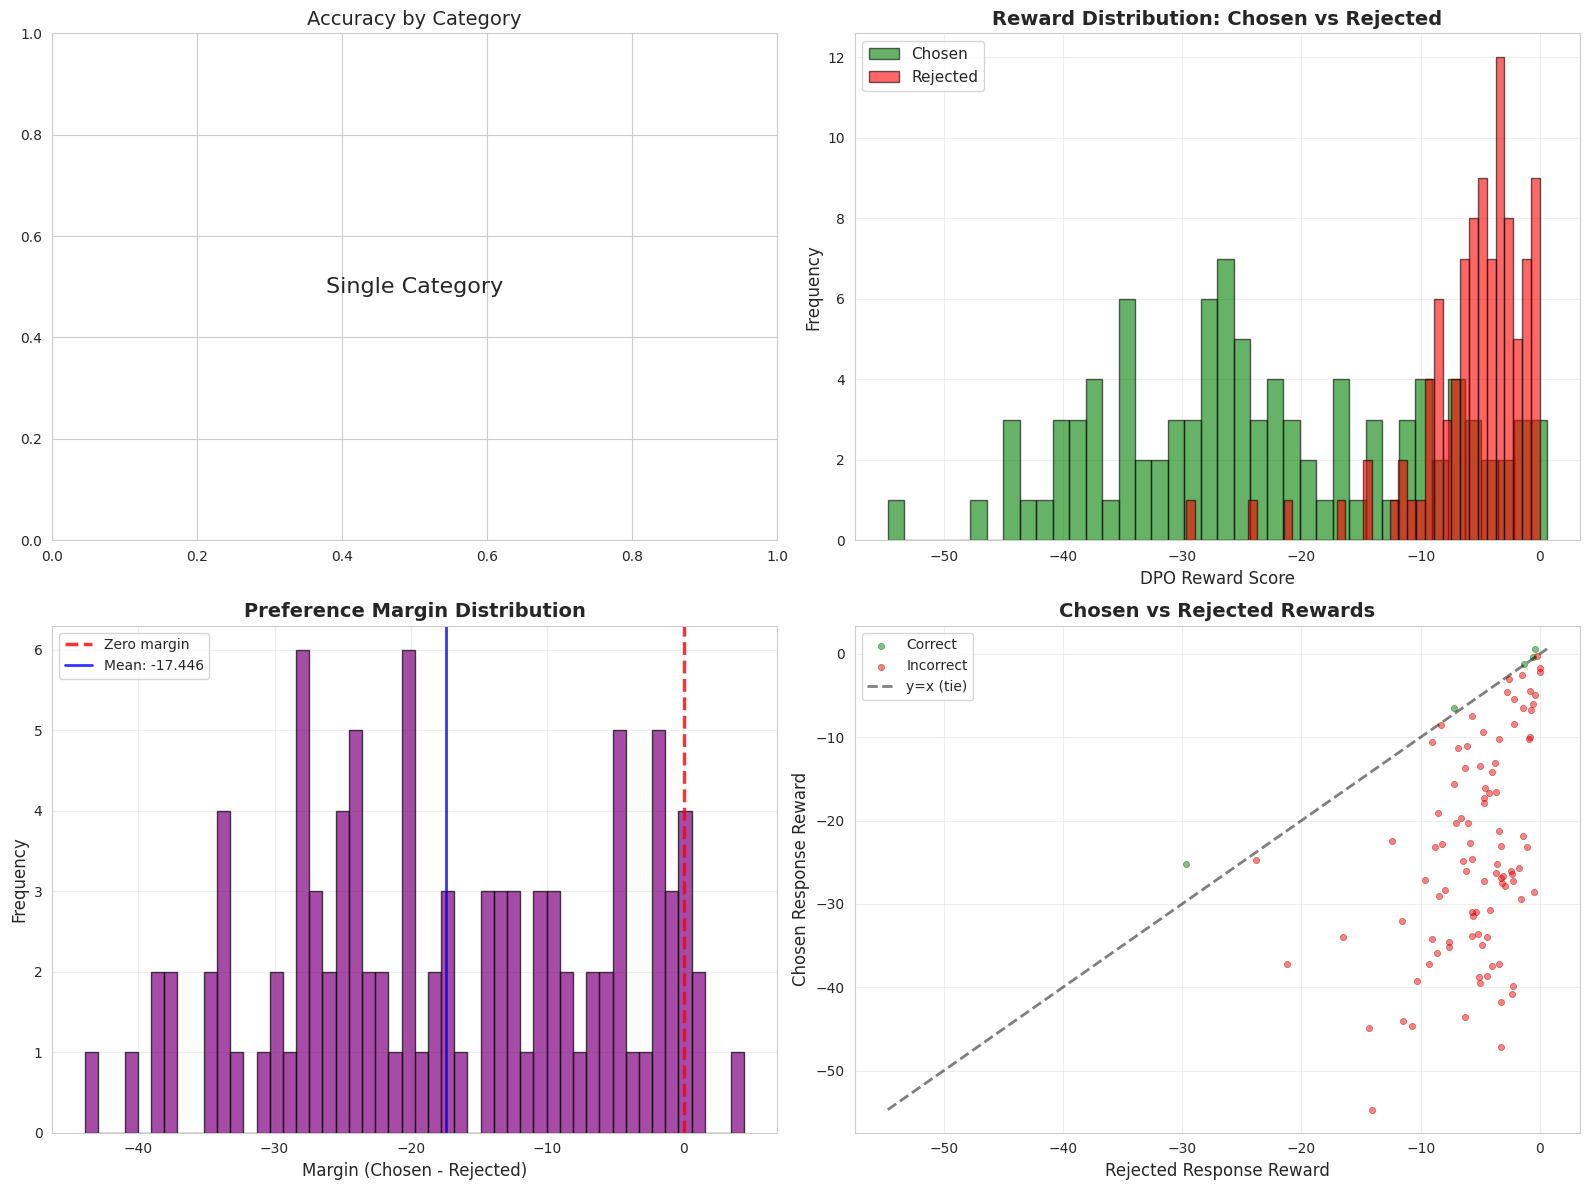

In [109]:
if results_df is not None and len(results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Accuracy by Category
    if "category" in results_df.columns and results_df["category"].nunique() > 1:
        category_acc = results_df.groupby("category")["correct"].mean() * 100
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(category_acc)))

        axes[0, 0].barh(category_acc.index, category_acc.values, color=colors)
        axes[0, 0].set_xlabel('Accuracy (%)', fontsize=12)
        axes[0, 0].set_title('DPO Model: Accuracy by Category', fontsize=14, fontweight='bold')
        axes[0, 0].axvline(x=50, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Random (50%)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    else:
        axes[0, 0].text(0.5, 0.5, 'Single Category', ha='center', va='center', fontsize=16)
        axes[0, 0].set_title('Accuracy by Category', fontsize=14)

    # 2. Reward Distribution (Chosen vs Rejected)
    axes[0, 1].hist(results_df["reward_chosen"], bins=40, alpha=0.6, label='Chosen', color='green', edgecolor='black')
    axes[0, 1].hist(results_df["reward_rejected"], bins=40, alpha=0.6, label='Rejected', color='red', edgecolor='black')
    axes[0, 1].set_xlabel('DPO Reward Score', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('Reward Distribution: Chosen vs Rejected', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Margin Distribution
    colors_margin = ['green' if x > 0 else 'red' for x in results_df["margin"]]
    axes[1, 0].hist(results_df["margin"], bins=50, color='purple', alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='Zero margin', alpha=0.8)
    axes[1, 0].axvline(x=results_df["margin"].mean(), color='blue', linestyle='-',
                       linewidth=2, label=f'Mean: {results_df["margin"].mean():.3f}', alpha=0.8)
    axes[1, 0].set_xlabel('Margin (Chosen - Rejected)', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)
    axes[1, 0].set_title('Preference Margin Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Scatter plot: Chosen vs Rejected Scores
    correct_mask = results_df["correct"]
    axes[1, 1].scatter(results_df[correct_mask]["reward_rejected"],
                      results_df[correct_mask]["reward_chosen"],
                      alpha=0.5, s=20, c='green', label='Correct', edgecolors='darkgreen', linewidth=0.5)
    axes[1, 1].scatter(results_df[~correct_mask]["reward_rejected"],
                      results_df[~correct_mask]["reward_chosen"],
                      alpha=0.5, s=20, c='red', label='Incorrect', edgecolors='darkred', linewidth=0.5)

    # Add diagonal line (y=x)
    min_val = min(results_df["reward_rejected"].min(), results_df["reward_chosen"].min())
    max_val = max(results_df["reward_rejected"].max(), results_df["reward_chosen"].max())
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=2, label='y=x (tie)')

    axes[1, 1].set_xlabel('Rejected Response Reward', fontsize=12)
    axes[1, 1].set_ylabel('Chosen Response Reward', fontsize=12)
    axes[1, 1].set_title('Chosen vs Rejected Rewards', fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('dpo_rewardbench_results.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved as 'dpo_rewardbench_results.png'")
    plt.show()

else:
    print("\n📊 Visualizing simple evaluation results...")

    if len(simple_results) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Plot 1: Scores comparison
        x = range(len(simple_results))
        chosen_scores = [float(r["Reward (Chosen)"]) for r in simple_results]
        rejected_scores = [float(r["Reward (Rejected)"]) for r in simple_results]

        ax1.plot(x, chosen_scores, 'go-', label='Chosen', linewidth=2.5, markersize=10)
        ax1.plot(x, rejected_scores, 'ro-', label='Rejected', linewidth=2.5, markersize=10)
        ax1.set_xlabel('Test Case', fontsize=12)
        ax1.set_ylabel('DPO Reward Score', fontsize=12)
        ax1.set_title('Simple Evaluation: Chosen vs Rejected', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)

        # Plot 2: Margins
        margins = [float(r["Margin"]) for r in simple_results]
        colors = ['green' if m > 0 else 'red' for m in margins]
        ax2.bar(x, margins, color=colors, alpha=0.7, edgecolor='black')
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax2.set_xlabel('Test Case', fontsize=12)
        ax2.set_ylabel('Margin', fontsize=12)
        ax2.set_title('Preference Margins', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig('dpo_simple_evaluation.png', dpi=300, bbox_inches='tight')
        print("\n✓ Visualization saved as 'dpo_simple_evaluation.png'")
        plt.show()


 ## 10. Save Results

In [110]:
# Save RewardBench results
if results_df is not None and len(results_df) > 0:
    output_path = "dpo_rewardbench_detailed_results.csv"
    results_df.to_csv(output_path, index=False)
    print(f"✓ Detailed RewardBench results saved to: {output_path}")

    # Save summary statistics
    summary = {
        "Metric": ["Accuracy (%)", "Average Margin", "Std Dev Margin", "Total Examples", "Correct", "Incorrect"],
        "Value": [
            f"{accuracy:.2f}",
            f"{avg_margin:.4f}",
            f"{std_margin:.4f}",
            len(results_df),
            results_df["correct"].sum(),
            (~results_df["correct"]).sum()
        ]
    }
    summary_df = pd.DataFrame(summary)
    summary_df.to_csv("dpo_rewardbench_summary.csv", index=False)
    print(f"✓ Summary saved to: dpo_rewardbench_summary.csv")

    # Save per-category stats
    if "category" in results_df.columns and results_df["category"].nunique() > 1:
        category_stats.to_csv("dpo_rewardbench_by_category.csv")
        print(f"✓ Per-category results saved to: dpo_rewardbench_by_category.csv")

# Save simple results
simple_df.to_csv("dpo_simple_evaluation_results.csv", index=False)
print(f"✓ Simple evaluation results saved to: dpo_simple_evaluation_results.csv")

print("\n" + "="*80)
print("✅ All results saved successfully!")
print("="*80)


✓ Detailed RewardBench results saved to: dpo_rewardbench_detailed_results.csv
✓ Summary saved to: dpo_rewardbench_summary.csv
✓ Simple evaluation results saved to: dpo_simple_evaluation_results.csv

✅ All results saved successfully!


 ## 11. Sample Predictions Analysis

In [111]:
if results_df is not None and len(results_df) > 0:
    print("\n" + "="*80)
    print("🔍 SAMPLE PREDICTIONS ANALYSIS")
    print("="*80)

    # Show high-confidence correct predictions
    print("\n✅ High-Confidence Correct Predictions (Top 3):")
    correct_samples = results_df[results_df["correct"]].nlargest(3, "margin")
    for idx, row in correct_samples.iterrows():
        print(f"\n  Example {row['example_id']} [{row['category']}]:")
        print(f"    Chosen Reward:   {row['reward_chosen']:>8.4f}")
        print(f"    Rejected Reward: {row['reward_rejected']:>8.4f}")
        print(f"    Margin:          {row['margin']:>8.4f} ⬆️")

    # Show incorrect predictions (where model failed)
    if not results_df[~results_df["correct"]].empty:
        print("\n❌ Incorrect Predictions (Top 3 by absolute margin):")
        incorrect_samples = results_df[~results_df["correct"]].nsmallest(3, "margin")
        for idx, row in incorrect_samples.iterrows():
            print(f"\n  Example {row['example_id']} [{row['category']}]:")
            print(f"    Chosen Reward:   {row['reward_chosen']:>8.4f}")
            print(f"    Rejected Reward: {row['reward_rejected']:>8.4f}")
            print(f"    Margin:          {row['margin']:>8.4f} ⬇️")

    # Show close calls (small margins)
    print("\n⚖️  Close Calls (Smallest Margins - Correct Predictions):")
    close_calls = results_df[results_df["correct"]].nsmallest(3, "margin")
    for idx, row in close_calls.iterrows():
        print(f"\n  Example {row['example_id']} [{row['category']}]:")
        print(f"    Chosen Reward:   {row['reward_chosen']:>8.4f}")
        print(f"    Rejected Reward: {row['reward_rejected']:>8.4f}")
        print(f"    Margin:          {row['margin']:>8.4f} (barely correct)")

print("\n" + "="*80)
print("✅ DPO MODEL EVALUATION COMPLETE!")
print("="*80)


🔍 SAMPLE PREDICTIONS ANALYSIS

✅ High-Confidence Correct Predictions (Top 3):

  Example 97 [alpacaeval-easy]:
    Chosen Reward:   -25.2000
    Rejected Reward: -29.6500
    Margin:            4.4500 ⬆️

  Example 52 [alpacaeval-easy]:
    Chosen Reward:     0.6000
    Rejected Reward:  -0.4094
    Margin:            1.0094 ⬆️

  Example 81 [alpacaeval-easy]:
    Chosen Reward:    -6.5000
    Rejected Reward:  -7.2250
    Margin:            0.7250 ⬆️

❌ Incorrect Predictions (Top 3 by absolute margin):

  Example 70 [alpacaeval-easy]:
    Chosen Reward:   -47.1500
    Rejected Reward:  -3.2625
    Margin:          -43.8875 ⬇️

  Example 13 [alpacaeval-easy]:
    Chosen Reward:   -54.7000
    Rejected Reward: -14.1000
    Margin:          -40.6000 ⬇️

  Example 35 [alpacaeval-easy]:
    Chosen Reward:   -41.8000
    Rejected Reward:  -3.2563
    Margin:          -38.5438 ⬇️

⚖️  Close Calls (Smallest Margins - Correct Predictions):

  Example 55 [alpacaeval-easy]:
    Chosen Reward:  

In [112]:
# Run both evaluations

results_summary = {}

# ==========================================
# 1. EVALUATE ON HH-RLHF TEST SET
# ==========================================

print("\n" + "="*80)
print("PHASE 1: HH-RLHF TEST SET (In-Distribution)")
print("="*80 + "\n")

from datasets import load_dataset

# Load HH-RLHF test
hh_dataset = load_dataset("Anthropic/hh-rlhf", data_dir="helpful-base", split="test")
print(f"Loaded {len(hh_dataset)} HH-RLHF test examples")

# Limit for speed (optional)
hh_dataset = hh_dataset.shuffle(seed=42).select(range(min(2000, len(hh_dataset))))

hh_results = []

for idx, example in enumerate(tqdm(hh_dataset, desc="Evaluating HH-RLHF")):
    try:
        chosen_text = example["chosen"]
        rejected_text = example["rejected"]

        # Extract last turn
        def get_last_turn(text):
            parts = text.split("\n\nAssistant:")
            if len(parts) < 2:
                return "", text.strip()
            prompt = parts[-2].split("\n\nHuman:")[-1].strip()
            response = parts[-1].strip()
            return prompt, response

        prompt_c, resp_c = get_last_turn(chosen_text)
        prompt_r, resp_r = get_last_turn(rejected_text)
        prompt = prompt_c if prompt_c else prompt_r

        if not prompt or not resp_c or not resp_r:
            continue

        result = get_dpo_preference_score(prompt, resp_c, resp_r)

        hh_results.append({
            "example_id": idx,
            "source": "HH-RLHF",
            "reward_chosen": result["reward_chosen"],
            "reward_rejected": result["reward_rejected"],
            "margin": result["margin"],
            "correct": result["correct"]
        })

    except Exception as e:
        continue

hh_df = pd.DataFrame(hh_results)
hh_accuracy = hh_df["correct"].mean() * 100
hh_margin = hh_df["margin"].mean()

results_summary["HH-RLHF Test"] = {
    "accuracy": hh_accuracy,
    "avg_margin": hh_margin,
    "n_examples": len(hh_df)
}

print(f"\n✓ HH-RLHF Results:")
print(f"  Accuracy: {hh_accuracy:.2f}%")
print(f"  Avg Margin: {hh_margin:.4f}")
print(f"  Examples: {len(hh_df)}")


# ==========================================
# 2. EVALUATE ON REWARDBENCH
# ==========================================

print("\n" + "="*80)
print("PHASE 2: REWARDBENCH (Out-of-Distribution)")
print("="*80 + "\n")

# Load RewardBench (use the code from earlier)
rb_dataset = load_dataset("allenai/reward-bench", split="filtered")
print(f"Available subsets: {rb_dataset.unique('subset')}")

# Take a sample from all subsets
rb_dataset = rb_dataset.shuffle(seed=42).select(range(min(2000, len(rb_dataset))))

rb_results = []

for idx, example in enumerate(tqdm(rb_dataset, desc="Evaluating RewardBench")):
    try:
        prompt = example["prompt"]
        chosen = example["chosen"]
        rejected = example["rejected"]

        if not prompt or not chosen or not rejected:
            continue

        result = get_dpo_preference_score(prompt, chosen, rejected)

        rb_results.append({
            "example_id": idx,
            "source": "RewardBench",
            "subset": example.get("subset", "unknown"),
            "reward_chosen": result["reward_chosen"],
            "reward_rejected": result["reward_rejected"],
            "margin": result["margin"],
            "correct": result["correct"]
        })

    except Exception as e:
        continue

rb_df = pd.DataFrame(rb_results)
rb_accuracy = rb_df["correct"].mean() * 100
rb_margin = rb_df["margin"].mean()

results_summary["RewardBench"] = {
    "accuracy": rb_accuracy,
    "avg_margin": rb_margin,
    "n_examples": len(rb_df)
}

print(f"\n✓ RewardBench Results:")
print(f"  Accuracy: {rb_accuracy:.2f}%")
print(f"  Avg Margin: {rb_margin:.4f}")
print(f"  Examples: {len(rb_df)}")


# ==========================================
# 3. COMPARISON ANALYSIS
# ==========================================

print("\n" + "="*80)
print("COMPARATIVE ANALYSIS")
print("="*80 + "\n")

comparison_df = pd.DataFrame({
    "Dataset": ["HH-RLHF Test", "RewardBench"],
    "Accuracy (%)": [hh_accuracy, rb_accuracy],
    "Avg Margin": [hh_margin, rb_margin],
    "Examples": [len(hh_df), len(rb_df)],
    "Type": ["In-Distribution", "Out-of-Distribution"]
})

display(comparison_df)

# Calculate generalization gap
gen_gap = hh_accuracy - rb_accuracy
print(f"\n📊 Generalization Gap: {gen_gap:.2f}%")

if gen_gap < 5:
    print("   ✅ Excellent generalization!")
elif gen_gap < 10:
    print("   ✓ Good generalization")
elif gen_gap < 15:
    print("   ⚠️  Moderate generalization - model may be overfitting to HH-RLHF")
else:
    print("   ❌ Poor generalization - significant overfitting detected")

# Per-subset analysis for RewardBench
if "subset" in rb_df.columns:
    print("\n📂 RewardBench Per-Subset Performance:")
    subset_perf = rb_df.groupby("subset")["correct"].agg(["mean", "count"])
    subset_perf["mean"] = (subset_perf["mean"] * 100).round(2)
    subset_perf.columns = ["Accuracy (%)", "Count"]
    display(subset_perf.sort_values("Accuracy (%)", ascending=False))


PHASE 1: HH-RLHF TEST SET (In-Distribution)

Loaded 2354 HH-RLHF test examples


Evaluating HH-RLHF:   0%|          | 0/2000 [00:00<?, ?it/s]


✓ HH-RLHF Results:
  Accuracy: 41.51%
  Avg Margin: -0.9840
  Examples: 1997

PHASE 2: REWARDBENCH (Out-of-Distribution)

Available subsets: ['alpacaeval-easy', 'alpacaeval-hard', 'alpacaeval-length', 'mt-bench-easy', 'mt-bench-med', 'mt-bench-hard', 'llmbar-natural', 'llmbar-adver-neighbor', 'llmbar-adver-GPTInst', 'llmbar-adver-GPTOut', 'llmbar-adver-manual', 'refusals-dangerous', 'refusals-offensive', 'xstest-should-respond', 'xstest-should-refuse', 'donotanswer', 'hep-python', 'hep-go', 'hep-cpp', 'hep-js', 'hep-rust', 'hep-java', 'math-prm']


Evaluating RewardBench:   0%|          | 0/2000 [00:00<?, ?it/s]


✓ RewardBench Results:
  Accuracy: 54.65%
  Avg Margin: 1.3454
  Examples: 2000

COMPARATIVE ANALYSIS



,Dataset,Accuracy (%),Avg Margin,Examples,Type
0,HH-RLHF Test,41.512268,-0.983964,1997,In-Distribution
1,RewardBench,54.650000,1.345384,2000,Out-of-Distribution



📊 Generalization Gap: -13.14%
   ✅ Excellent generalization!

📂 RewardBench Per-Subset Performance:


,Accuracy (%),Count
subset,,
refusals-dangerous,93.33,60
llmbar-adver-neighbor,87.10,93
xstest-should-refuse,81.63,98
llmbar-adver-GPTInst,81.03,58
math-prm,77.81,302
llmbar-adver-manual,73.53,34
refusals-offensive,71.43,63
donotanswer,69.23,91
llmbar-adver-GPTOut,60.00,30



COMPARISON: Evaluating With vs Without Reference Model

Loading test data...
Loaded 1000 examples for comparison

1️⃣  EVALUATING WITHOUT REFERENCE MODEL


Without reference:   0%|          | 0/1000 [00:00<?, ?it/s]


✓ Results WITHOUT reference model:
  Accuracy:    55.80%
  Avg Margin:  0.2022
  Examples:    1000

2️⃣  EVALUATING WITH REFERENCE MODEL

Testing with BETA = 0.1


With ref (β=0.1):   0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy:    42.30%
  Avg Margin:  -1.1060

Testing with BETA = 0.5


With ref (β=0.5):   0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy:    42.30%
  Avg Margin:  -5.5299

Testing with BETA = 1.0


With ref (β=1.0):   0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy:    42.30%
  Avg Margin:  -11.0598

📊 COMPARISON SUMMARY



,Method,Accuracy (%),Avg Margin,Examples
0,No Reference,55.8,0.202191,1000
1,With Ref (β=0.1),42.3,-1.105978,1000
2,With Ref (β=0.5),42.3,-5.529891,1000
3,With Ref (β=1.0),42.3,-11.059781,1000



🏆 Best Method: No Reference with 55.80% accuracy

🔍 ANALYSIS
⚠️  Performance DROPS significantly with reference model
  → Possible issues:
    1. Reference model might not match the base model used for DPO
    2. Beta value might be too small
    3. Implementation might have an error
  → Recommendation: Use WITHOUT reference model

✓ Visualization saved as 'reference_model_comparison.png'


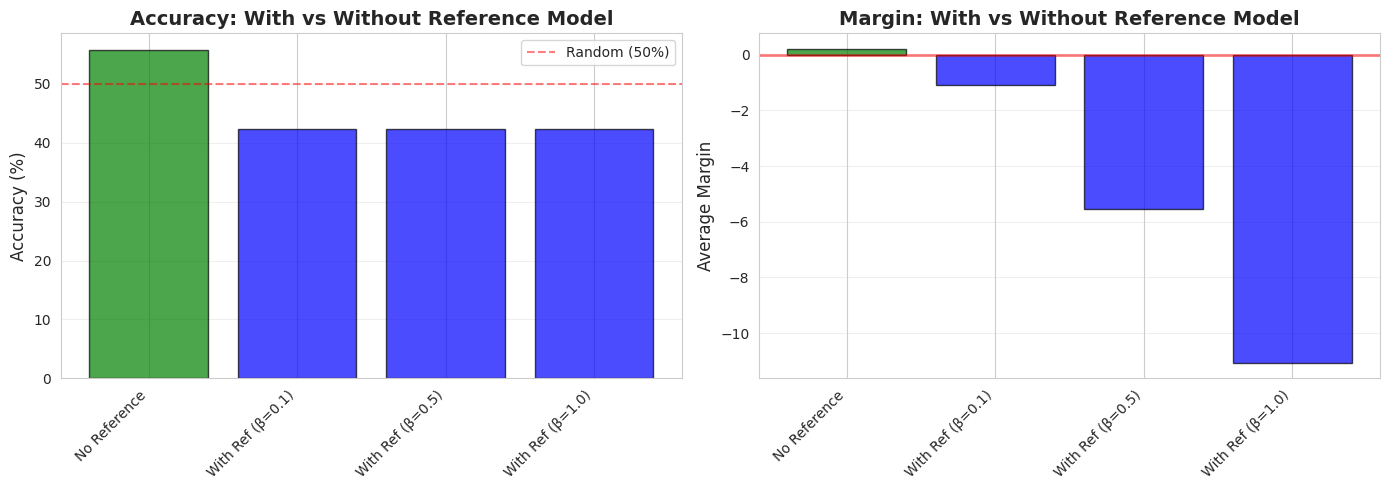


✅ COMPARISON COMPLETE


In [113]:
# ==========================================
# COMPARISON: With vs Without Reference Model
# ==========================================

print("\n" + "="*80)
print("COMPARISON: Evaluating With vs Without Reference Model")
print("="*80)

# Load a small test dataset
from datasets import load_dataset

print("\nLoading test data...")
test_data = load_dataset("Anthropic/hh-rlhf", data_dir="helpful-base", split="test")
test_data = test_data.shuffle(seed=42).select(range(1000))  # Just 50 examples for comparison

print(f"Loaded {len(test_data)} examples for comparison\n")

# Helper function to extract prompt and responses from HH-RLHF format
def extract_from_hh(text):
    """Extract prompt and response from HH-RLHF format"""
    parts = text.split("\n\nAssistant:")
    if len(parts) < 2:
        return "", text.strip()
    prompt = parts[-2].split("\n\nHuman:")[-1].strip() if "\n\nHuman:" in parts[-2] else parts[-2].strip()
    response = parts[-1].strip()
    return prompt, response


# ==========================================
# 1. EVALUATE WITHOUT REFERENCE MODEL
# ==========================================

print("="*80)
print("1️⃣  EVALUATING WITHOUT REFERENCE MODEL")
print("="*80)

# Disable reference model
reference_model_backup = reference_model  # Save it
reference_model = None

results_no_ref = []

for idx, example in enumerate(tqdm(test_data, desc="Without reference")):
    try:
        chosen_text = example["chosen"]
        rejected_text = example["rejected"]

        prompt_c, resp_c = extract_from_hh(chosen_text)
        prompt_r, resp_r = extract_from_hh(rejected_text)
        prompt = prompt_c if prompt_c else prompt_r

        if not prompt or not resp_c or not resp_r:
            continue

        result = get_dpo_preference_score(prompt, resp_c, resp_r)
        results_no_ref.append(result)

    except Exception as e:
        continue

# Calculate metrics
df_no_ref = pd.DataFrame(results_no_ref)
acc_no_ref = df_no_ref["correct"].mean() * 100
margin_no_ref = df_no_ref["margin"].mean()

print(f"\n✓ Results WITHOUT reference model:")
print(f"  Accuracy:    {acc_no_ref:.2f}%")
print(f"  Avg Margin:  {margin_no_ref:.4f}")
print(f"  Examples:    {len(df_no_ref)}")


# ==========================================
# 2. EVALUATE WITH REFERENCE MODEL
# ==========================================

print("\n" + "="*80)
print("2️⃣  EVALUATING WITH REFERENCE MODEL")
print("="*80)

# Load reference model if not already loaded
if reference_model_backup is None:
    print("Loading reference model...")
    reference_model = AutoModelForCausalLM.from_pretrained(
        REFERENCE_MODEL_PATH,
        torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
    )
    reference_model.to(DEVICE)
    reference_model.eval()
    print("✓ Reference model loaded")
else:
    reference_model = reference_model_backup

# Try different beta values
BETA_VALUES = [0.1, 0.5, 1.0]

results_with_ref_by_beta = {}

for beta in BETA_VALUES:
    print(f"\nTesting with BETA = {beta}")
    BETA = beta

    results_with_ref = []

    for idx, example in enumerate(tqdm(test_data, desc=f"With ref (β={beta})")):
        try:
            chosen_text = example["chosen"]
            rejected_text = example["rejected"]

            prompt_c, resp_c = extract_from_hh(chosen_text)
            prompt_r, resp_r = extract_from_hh(rejected_text)
            prompt = prompt_c if prompt_c else prompt_r

            if not prompt or not resp_c or not resp_r:
                continue

            result = get_dpo_preference_score(prompt, resp_c, resp_r)
            results_with_ref.append(result)

        except Exception as e:
            continue

    # Calculate metrics
    df_with_ref = pd.DataFrame(results_with_ref)
    acc_with_ref = df_with_ref["correct"].mean() * 100
    margin_with_ref = df_with_ref["margin"].mean()

    results_with_ref_by_beta[beta] = {
        "accuracy": acc_with_ref,
        "margin": margin_with_ref,
        "count": len(df_with_ref)
    }

    print(f"  Accuracy:    {acc_with_ref:.2f}%")
    print(f"  Avg Margin:  {margin_with_ref:.4f}")


# ==========================================
# 3. COMPARISON TABLE
# ==========================================

print("\n" + "="*80)
print("📊 COMPARISON SUMMARY")
print("="*80 + "\n")

comparison_data = {
    "Method": ["No Reference"] + [f"With Ref (β={b})" for b in BETA_VALUES],
    "Accuracy (%)": [acc_no_ref] + [results_with_ref_by_beta[b]["accuracy"] for b in BETA_VALUES],
    "Avg Margin": [margin_no_ref] + [results_with_ref_by_beta[b]["margin"] for b in BETA_VALUES],
    "Examples": [len(df_no_ref)] + [results_with_ref_by_beta[b]["count"] for b in BETA_VALUES]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# Show which is best
best_idx = comparison_df["Accuracy (%)"].idxmax()
best_method = comparison_df.loc[best_idx, "Method"]
best_accuracy = comparison_df.loc[best_idx, "Accuracy (%)"]

print(f"\n🏆 Best Method: {best_method} with {best_accuracy:.2f}% accuracy")

# Analysis
print("\n" + "="*80)
print("🔍 ANALYSIS")
print("="*80)

diff = acc_no_ref - results_with_ref_by_beta[0.1]["accuracy"]

if abs(diff) < 2:
    print("✓ Reference model has minimal impact (~same performance)")
    print("  → Recommendation: Don't use reference model (simpler & faster)")
elif diff > 5:
    print("⚠️  Performance DROPS significantly with reference model")
    print("  → Possible issues:")
    print("    1. Reference model might not match the base model used for DPO")
    print("    2. Beta value might be too small")
    print("    3. Implementation might have an error")
    print("  → Recommendation: Use WITHOUT reference model")
elif diff < -5:
    print("✓ Performance IMPROVES with reference model")
    print("  → This is unusual but possible")
    print("  → Recommendation: Use WITH reference model")
else:
    print("~ Small difference between methods")
    print(f"  → Without ref: {acc_no_ref:.2f}%")
    print(f"  → With ref (β=0.1): {results_with_ref_by_beta[0.1]['accuracy']:.2f}%")
    print("  → Recommendation: Use WITHOUT reference (simpler)")


# ==========================================
# 4. VISUAL COMPARISON
# ==========================================

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison
methods = comparison_df["Method"]
accuracies = comparison_df["Accuracy (%)"]
colors = ['green'] + ['blue']*len(BETA_VALUES)

ax1.bar(range(len(methods)), accuracies, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Accuracy: With vs Without Reference Model', fontsize=14, fontweight='bold')
ax1.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Margin comparison
margins = comparison_df["Avg Margin"]

ax2.bar(range(len(methods)), margins, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(methods)))
ax2.set_xticklabels(methods, rotation=45, ha='right')
ax2.set_ylabel('Average Margin', fontsize=12)
ax2.set_title('Margin: With vs Without Reference Model', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='red', linestyle='-', alpha=0.5, linewidth=2)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('reference_model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'reference_model_comparison.png'")
plt.show()

print("\n" + "="*80)
print("✅ COMPARISON COMPLETE")
print("="*80)